## Derive an RE24 matrix and LWTS from PBP data

Following the methodology described here: https://library.fangraphs.com/the-beginners-guide-to-deriving-woba/

Basic steps:

1. Compute an RE24 table by grouping all events based on starting base-out state and looking at runs scored from those situations.
2. For each PA, add the starting RE, ending RE, and the change in RE.
3. Group all of that by event type to get an average run value for each event type.
4. Store off a PA data table, which includes RE and run value fields, to use in further analysis.

Now that we have this PA table, there are all sorts of things we could do next:
* Compute wOBA weights
* Aggregate run value or RE along various dimensions (e.g., on batter or pitcher)
* Create a model to predict run value of a particular PA (e.g., based on batter and pitcher stats)

In [1]:
import pandas as pd
import numpy as np

In [2]:
YEARS = range(2015, 2020)

In [3]:
ev = pd.read_parquet('../data/retro/event.parquet')

In [4]:
# Add a couple columns for computing RE24
ev['runs_finish_ct']=ev.fate_runs_ct+ev.event_runs_ct #total runs in remainder of inning
ev['end_outs_ct']=ev.outs_ct+ev.event_outs_ct # outs at end of event

In [5]:
# Choose which games we want
gm = pd.read_parquet('../data/mine/gamelog_enhanced.parquet')
gms = gm[(gm.yr.isin(YEARS)) & (gm.game_type=='RS')]

evs = ev[ev.game_id.isin(gms.game_id)]
evs.shape

(954579, 162)

In [6]:
# Generate a basic RE24 table
re24 = evs.groupby(['start_bases_cd', 'outs_ct'])['runs_finish_ct'].mean().unstack()
re24[3] = re24[2]*0
re24 = re24.unstack()
re24

outs_ct  start_bases_cd
0        0                 0.507341
         1                 0.893050
         2                 1.146264
         3                 1.483383
         4                 1.401240
         5                 1.768003
         6                 1.999087
         7                 2.248916
1        0                 0.271818
         1                 0.530693
         2                 0.696156
         3                 0.943318
         4                 0.978075
         5                 1.197856
         6                 1.403012
         7                 1.575237
2        0                 0.105642
         1                 0.228494
         2                 0.322398
         3                 0.442104
         4                 0.371723
         5                 0.497049
         6                 0.576598
         7                 0.771961
3        0                 0.000000
         1                 0.000000
         2                 0.000000
    

In [8]:
gms.shape

(12147, 164)

In [9]:
half_innings = len(evs.groupby(['game_id', 'inn_ct', 'bat_home_id']))
half_innings

217513

In [10]:
# Now compute RE24 for each event
def add_REs_to_events(evs):
    # Add the re_start and re_end to each event (merge is faster than a lookup)
    e_s = pd.merge(left=evs, right=re24.rename('re_start'), on=['start_bases_cd', 'outs_ct'])
    e_e = pd.merge(left=e_s, right=re24.rename('re_end'), \
               left_on=['end_bases_cd', 'end_outs_ct'], \
               right_on=['start_bases_cd', 'outs_ct'])
    e_e['re_added'] = e_e['re_end'] - e_e['re_start'] + e_e['event_runs_ct']
    return e_e.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

In [11]:
evs_re = add_REs_to_events(evs)
evs_re.head(20)

,game_id,away_team_id,inn_ct,bat_home_id,outs_ct,balls_ct,strikes_ct,pitch_seq_tx,away_score_ct,home_score_ct,...,ass8_fld_cd,ass9_fld_cd,ass10_fld_cd,unknown_out_exc_fl,uncertain_play_exc_fl,runs_finish_ct,end_outs_ct,re_start,re_end,re_added
61875,ANA201504100,KCA,1,False,0,2,2,FSBFBX,0,0,...,0,0,0,False,False,1,1,0.507341,0.271818,-0.235523
296116,ANA201504100,KCA,1,False,1,0,0,X,0,0,...,0,0,0,False,False,1,2,0.271818,0.105642,-0.166176
655500,ANA201504100,KCA,1,False,2,1,0,BX,0,0,...,0,0,0,False,False,1,2,0.105642,0.322398,0.216755
646988,ANA201504100,KCA,1,False,2,2,2,CBFFB>X,0,0,...,0,0,0,False,False,1,2,0.322398,0.228494,0.906097
747960,ANA201504100,KCA,1,False,2,2,2,FBBFX,1,0,...,0,0,0,False,False,0,2,0.228494,0.442104,0.213610
878209,ANA201504100,KCA,1,False,2,0,2,CSX,1,0,...,0,0,0,False,False,0,3,0.442104,0.000000,-0.442104
61876,ANA201504100,KCA,1,True,0,2,2,CFBBFX,1,0,...,0,0,0,False,False,0,1,0.507341,0.271818,-0.235523
296117,ANA201504100,KCA,1,True,1,2,1,CBBX,1,0,...,0,0,0,False,False,0,2,0.271818,0.105642,-0.166176
521789,ANA201504100,KCA,1,True,2,2,2,FBBFX,1,0,...,0,0,0,False,False,0,3,0.105642,0.000000,-0.105642
61877,ANA201504100,KCA,2,False,0,3,2,CBFBFBFFX,1,0,...,0,0,0,False,False,0,1,0.507341,0.271818,-0.235523


In [12]:
# Just to sanity check, let's compute the sum by pitcher
evs_re.groupby('pit_id')['re_added'].sum().sort_values()

pit_id
schem001   -204.223583
kersc001   -198.943571
degrj001   -185.380748
verlj001   -167.586363
greiz001   -152.217305
               ...    
perdl002     54.234180
coved001     56.172725
perem004     64.320723
jacke001     69.164091
zimmj003     70.742405
Name: re_added, Length: 1525, dtype: float64

In [13]:
# What does total re_added sum to?
evs_re.re_added.sum()

385.8544146102241

We might've expected the sum to come out to zero.  But it doesn't exactly, because RE24[0][0] isn't exactly equal to the the number of runs per inning.  This is because there are other [0][0] occurrences (e.g., after a leadoff HR) that are included in the re24[0][0] calculation.

In [14]:
evs_re[evs_re.game_end_fl].re_end.sum()

669.1849291373048

In [15]:
# Now look at average RE change by event code
# This is the context-neutral run value of each event type
event_res = evs_re.groupby('event_cd').agg({'re_added': np.mean})['re_added'].rename('event_re')
event_res

event_cd
2    -0.271886
3    -0.271281
4     0.178672
5     0.103831
6    -0.429733
8    -0.230198
9     0.260823
10    0.273917
11    0.267580
12   -0.379469
13    0.000000
14    0.311092
15    0.174943
16    0.331550
17    0.352773
18    0.486625
19   -0.162358
20    0.450036
21    0.755653
22    1.045467
23    1.380405
Name: event_re, dtype: float64

In [16]:
# Annotate each event with the context-neutral run value of the event type
evs_re = pd.merge(left=evs_re, right=event_res, on='event_cd') \
    .sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

evs_re.head(20)

,game_id,away_team_id,inn_ct,bat_home_id,outs_ct,balls_ct,strikes_ct,pitch_seq_tx,away_score_ct,home_score_ct,...,ass9_fld_cd,ass10_fld_cd,unknown_out_exc_fl,uncertain_play_exc_fl,runs_finish_ct,end_outs_ct,re_start,re_end,re_added,event_re
0,ANA201504100,KCA,1,False,0,2,2,FSBFBX,0,0,...,0,0,False,False,1,1,0.507341,0.271818,-0.235523,-0.271886
1,ANA201504100,KCA,1,False,1,0,0,X,0,0,...,0,0,False,False,1,2,0.271818,0.105642,-0.166176,-0.271886
419128,ANA201504100,KCA,1,False,2,1,0,BX,0,0,...,0,0,False,False,1,2,0.105642,0.322398,0.216755,0.755653
460816,ANA201504100,KCA,1,False,2,2,2,CBFFB>X,0,0,...,0,0,False,False,1,2,0.322398,0.228494,0.906097,0.450036
460817,ANA201504100,KCA,1,False,2,2,2,FBBFX,1,0,...,0,0,False,False,0,2,0.228494,0.442104,0.213610,0.450036
2,ANA201504100,KCA,1,False,2,0,2,CSX,1,0,...,0,0,False,False,0,3,0.442104,0.000000,-0.442104,-0.271886
3,ANA201504100,KCA,1,True,0,2,2,CFBBFX,1,0,...,0,0,False,False,0,1,0.507341,0.271818,-0.235523,-0.271886
4,ANA201504100,KCA,1,True,1,2,1,CBBX,1,0,...,0,0,False,False,0,2,0.271818,0.105642,-0.166176,-0.271886
5,ANA201504100,KCA,1,True,2,2,2,FBBFX,1,0,...,0,0,False,False,0,3,0.105642,0.000000,-0.105642,-0.271886
6,ANA201504100,KCA,2,False,0,3,2,CBFBFBFFX,1,0,...,0,0,False,False,0,1,0.507341,0.271818,-0.235523,-0.271886


In [17]:
# Let's repeat the sanity check, let's compute the sum by pitcher
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('pit_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
pit_id,,
schem001,-204.223583,-218.016370
kersc001,-198.943571,-196.381314
degrj001,-185.380748,-183.051583
verlj001,-167.586363,-187.705060
greiz001,-152.217305,-163.499129
...,...,...
perdl002,54.234180,49.707401
coved001,56.172725,43.543307
perem004,64.320723,62.766893


In [18]:
# Now repeat for batters
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('bat_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
bat_id,,
hamib001,-109.415363,-108.607058
escoa003,-94.906223,-103.961345
maldm001,-74.495219,-58.236515
mathj001,-62.234666,-62.535003
mccaj001,-61.880764,-39.647251
...,...,...
vottj001,218.555280,223.561368
goldp001,225.559077,222.047664
harpb003,239.550592,196.216964


In [19]:
# Now to get wOBA weights.  We need to first limit to batter-events
pa = evs_re[evs_re.bat_event_fl==True].rename(columns={'h_fl': 'tb_ct'})
pa['h_fl'] = pa['tb_ct'].apply(lambda tb: tb>0)
pa['ob_fl'] = pa['event_cd'].apply(lambda e: e in (14, 16, 20, 21, 22, 23))
pa.shape

(925159, 168)

In [20]:
pa.groupby('event_cd').agg({'re_added': np.mean})

,re_added
event_cd,
2,-0.271886
3,-0.271281
14,0.311092
15,0.174943
16,0.331550
17,0.352773
18,0.486625
19,-0.162358
20,0.450036


In [21]:
# We'll start simple: consider only uBB, HBP, 1B, 2B, 3B, HR; ignore IBB and Interference; everything else is an "out"

# First the positives
success_cols = [14, 16, 20, 21, 22, 23]
ignore_cols = [15, 17]
success_weights = pa[pa.event_cd.isin(success_cols)].groupby('event_cd') \
    .agg({'re_added': [len, np.mean]})['re_added'] \
    .rename(columns={'len': 'ct', 'mean': 're_added'})

success_weights

,ct,re_added
event_cd,,
14,72036.0,0.311092
16,8922.0,0.331550
20,134742.0,0.450036
21,41688.0,0.755653
22,4239.0,1.045467
23,28985.0,1.380405


In [22]:
out_weights = pa[~pa.event_cd.isin(success_cols+ignore_cols)] \
    .agg({'re_added': [len, np.mean]}) \
    .rename(columns={'re_added': 'out'}) \
    .T.rename(columns={'len': 'ct', 'mean': 're_added'})
out_weights

,ct,re_added
out,629793.0,-0.262131


In [23]:
weights = pd.concat([success_weights, out_weights])
weights

,ct,re_added
14,72036.0,0.311092
16,8922.0,0.331550
20,134742.0,0.450036
21,41688.0,0.755653
22,4239.0,1.045467
23,28985.0,1.380405
out,629793.0,-0.262131


In [24]:
out_value=out_weights['re_added'][0]
out_value

-0.26213141383043875

In [25]:
weights['re_over_out'] = weights.re_added-out_value
weights

,ct,re_added,re_over_out
14,72036.0,0.311092,0.573223
16,8922.0,0.331550,0.593682
20,134742.0,0.450036,0.712167
21,41688.0,0.755653,1.017785
22,4239.0,1.045467,1.307598
23,28985.0,1.380405,1.642537
out,629793.0,-0.262131,0.000000


In [26]:
raw_woba = sum(weights['ct']*weights['re_over_out'])/sum(weights['ct'])
raw_woba

0.2587226054652001

In [27]:
sum(weights['ct']*weights['re_over_out'])

238129.57968319752

In [28]:
target_woba = .315
woba_scale = target_woba/raw_woba
weights['woba_wt'] = weights['re_over_out']*woba_scale
weights, woba_scale

(           ct  re_added  re_over_out   woba_wt
 14    72036.0  0.311092     0.573223  0.697911
 16     8922.0  0.331550     0.593682  0.722820
 20   134742.0  0.450036     0.712167  0.867078
 21    41688.0  0.755653     1.017785  1.239173
 22     4239.0  1.045467     1.307598  1.592027
 23    28985.0  1.380405     1.642537  1.999821
 out  629793.0 -0.262131     0.000000  0.000000,
 1.2175202063755097)

OK, so that gives us wOBA weights!

In [29]:
def summarize_stats(pa, groupby):
    counters_map = {'bat_event_fl': 'pa', 'ob_fl': 'ob', 'ab_fl': 'ab', 'h_fl': 'h', 'tb_ct': 'tb'}
    groups = pa.groupby(groupby)
    stats = groups[list(counters_map.keys())].sum().rename(columns=counters_map)
    stats['ba'] = stats['h']/stats['ab']
    stats['obp'] = stats['ob']/stats['pa']
    stats['slg'] = stats['tb']/stats['ab']
    woba_weights = {'ob': .702, 'tb': .37, 'h': -.21}
    stats['woba'] = sum([stats[stat]*woba_weights[stat] for stat in woba_weights.keys()])/stats['pa']
    return stats

In [30]:
summarize_stats(pa, ['bat_hand_cd'])

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_hand_cd,,,,,,,,,
?,17.0,6.0,13.0,4.0,8.0,0.307692,0.352941,0.615385,0.372471
L,382846.0,122449.0,340209.0,86221.0,142661.0,0.253435,0.319839,0.419333,0.315107
R,542296.0,168157.0,488477.0,123429.0,204106.0,0.252681,0.310083,0.417842,0.309140


## Modeling individual PAs

### Measure outcome: run value based on event code
### Batter estimate (wOBA)
### Pitcher estimate (wOBA allowed)
### Regression or other model

In [31]:
batters = pa.groupby('bat_id')['event_re'].mean().rename('bat_re_avg')
batters

bat_id
aardd001   -0.271281
abadf001   -0.271281
abrej003    0.029350
ackld001   -0.036186
acunr001    0.049827
              ...   
zimmb001   -0.027089
zimmj003   -0.162328
zimmr001    0.014055
zobrb001    0.016716
zunim001   -0.028716
Name: bat_re_avg, Length: 1893, dtype: float64

In [32]:
pitchers = pa.groupby('pit_id')['event_re'].mean().rename('pit_re_avg')
pitchers

pit_id
aardd001    0.003545
abadf001   -0.013281
abreb002   -0.117195
achta001    0.028408
adama001    0.044904
              ...   
zimmj003    0.014245
zimmk001    0.097912
zitob001    0.194421
zobrb001   -0.038574
zycht001   -0.035355
Name: pit_re_avg, Length: 1525, dtype: float64

In [33]:
pa = pd.merge(left=pa, right=batters, on='bat_id')
pa = pd.merge(left=pa, right=pitchers, on='pit_id')

In [34]:
pa = pa.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])
pa

,game_id,away_team_id,inn_ct,bat_home_id,outs_ct,balls_ct,strikes_ct,pitch_seq_tx,away_score_ct,home_score_ct,...,runs_finish_ct,end_outs_ct,re_start,re_end,re_added,event_re,h_fl,ob_fl,bat_re_avg,pit_re_avg
0,ANA201504100,KCA,1,False,0,2,2,FSBFBX,0,0,...,1,1,0.507341,0.271818,-0.235523,-0.271886,False,False,-0.043387,0.011729
21,ANA201504100,KCA,1,False,1,0,0,X,0,0,...,1,2,0.271818,0.105642,-0.166176,-0.271886,False,False,0.020042,0.011729
33,ANA201504100,KCA,1,False,2,1,0,BX,0,0,...,1,2,0.105642,0.322398,0.216755,0.755653,True,True,0.019558,0.011729
53,ANA201504100,KCA,1,False,2,2,2,CBFFB>X,0,0,...,1,2,0.322398,0.228494,0.906097,0.450036,True,True,0.012686,0.011729
75,ANA201504100,KCA,1,False,2,2,2,FBBFX,1,0,...,0,2,0.228494,0.442104,0.213610,0.450036,True,True,0.009354,0.011729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149879,WAS201909290,CLE,8,True,1,1,2,SC*BS,2,8,...,0,2,1.197856,0.497049,-0.700807,-0.271281,False,False,-0.038235,-0.020649
150020,WAS201909290,CLE,8,True,2,0,0,X,2,8,...,0,3,0.497049,0.000000,-0.497049,-0.271886,False,False,-0.271886,-0.020649
693541,WAS201909290,CLE,9,False,0,3,2,BBCFBB,2,8,...,0,0,0.507341,0.893050,0.385709,0.311092,False,True,-0.018411,0.029530
693537,WAS201909290,CLE,9,False,0,2,1,.BBFX,2,8,...,0,2,0.893050,0.105642,-0.787408,-0.271886,False,False,0.000341,0.029530


In [35]:
import statsmodels.api as sm

In [36]:
X = pa[['bat_re_avg', 'pit_re_avg']]
y = pa['event_re']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5956.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:43:13   Log-Likelihood:            -5.1400e+05
No. Observations:              925159   AIC:                         1.028e+06
Df Residuals:                  925156   BIC:                         1.028e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000      5.620      0.000       0.002       0.003
bat_re_avg     1.0037      0.011     90.710      0.000       0.982       1.025
pit_re_avg     1.0082      0.016     61.195      0.000       0.976       1.040
==============================================================================
Omnibus:                   211379.196   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           400134.712
Skew:                           1.437   Prob(JB):                         0.00
Kurtosis:                       4.458   Cond. No.                         37.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
predictions

0        -0.029243
21        0.034420
33        0.033934
53        0.027037
75        0.023693
            ...   
149879   -0.056716
150020   -0.291231
693541    0.013772
693537    0.032593
693542   -0.113968
Length: 925159, dtype: float64

In [38]:
pa['re_predicted']=predictions

In [39]:
pa.groupby('bat_id')['re_predicted'].sum().sort_values()

bat_id
hamib001   -112.643904
escoa003   -110.748508
galvf001    -73.794286
owinc001    -72.266927
mathj001    -66.211981
               ...    
harpb003    186.708124
goldp001    200.632842
vottj001    202.428036
martj006    203.649406
troum001    291.060893
Name: re_predicted, Length: 1893, dtype: float64

In [40]:
pa.to_parquet('../data/mine/pa2015-2019.parquet')

OK, so now we can predict individual PAs.  The r^2 is very low (.013) because of the variability of PAs.  How about if we look at cohorts?

In [41]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not batters
bat_buckets = pd.qcut(pa.bat_re_avg, q=20).rename('bat_bucket')
bat_buckets

0          (-0.0583, -0.0383]
21           (0.0181, 0.0222]
33           (0.0181, 0.0222]
53          (0.00988, 0.0141]
75         (0.00704, 0.00988]
                 ...         
149879     (-0.0383, -0.0287]
150020      (-0.273, -0.0583]
693541     (-0.0218, -0.0164]
693537    (-0.000939, 0.0023]
693542      (-0.273, -0.0583]
Name: bat_bucket, Length: 925159, dtype: category
Categories (20, interval[float64]): [(-0.273, -0.0583] < (-0.0583, -0.0383] < (-0.0383, -0.0287] < (-0.0287, -0.0218] ... (0.0222, 0.0287] < (0.0287, 0.0348] < (0.0348, 0.0505] < (0.0505, 0.756]]

In [42]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not pitchers
pit_buckets = pd.qcut(pa.pit_re_avg, q=20).rename('pit_bucket')
pit_buckets

0           (0.0102, 0.014]
21          (0.0102, 0.014]
33          (0.0102, 0.014]
53          (0.0102, 0.014]
75          (0.0102, 0.014]
                ...        
149879    (-0.022, -0.0182]
150020    (-0.022, -0.0182]
693541     (0.0253, 0.0399]
693537     (0.0253, 0.0399]
693542     (0.0253, 0.0399]
Name: pit_bucket, Length: 925159, dtype: category
Categories (20, interval[float64]): [(-0.273, -0.0419] < (-0.0419, -0.0328] < (-0.0328, -0.0273] < (-0.0273, -0.022] ... (0.014, 0.0186] < (0.0186, 0.0253] < (0.0253, 0.0399] < (0.0399, 0.915]]

In [43]:
pa.groupby(bat_buckets)['bat_re_avg'].mean()

bat_bucket
(-0.273, -0.0583]       -0.124164
(-0.0583, -0.0383]      -0.045441
(-0.0383, -0.0287]      -0.032628
(-0.0287, -0.0218]      -0.024301
(-0.0218, -0.0164]      -0.019107
(-0.0164, -0.0112]      -0.013662
(-0.0112, -0.00777]     -0.009369
(-0.00777, -0.00375]    -0.005514
(-0.00375, -0.000939]   -0.002406
(-0.000939, 0.0023]      0.000666
(0.0023, 0.00477]        0.003670
(0.00477, 0.00704]       0.005943
(0.00704, 0.00988]       0.008351
(0.00988, 0.0141]        0.012256
(0.0141, 0.0181]         0.015844
(0.0181, 0.0222]         0.019974
(0.0222, 0.0287]         0.026316
(0.0287, 0.0348]         0.031362
(0.0348, 0.0505]         0.043915
(0.0505, 0.756]          0.061615
Name: bat_re_avg, dtype: float64

In [44]:
summarize_stats(pa, bat_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_bucket,,,,,,,,,
"(-0.273, -0.0583]",46415.0,8417.0,41634.0,6313.0,8611,0.151631,0.181342,0.206826,0.167383
"(-0.0583, -0.0383]",46463.0,12772.0,42327.0,9455.0,13981,0.223380,0.274885,0.330309,0.261571
"(-0.0383, -0.0287]",47536.0,13629.0,43018.0,9869.0,15184,0.229416,0.286709,0.352969,0.275857
"(-0.0287, -0.0218]",45612.0,13458.0,41556.0,10103.0,15352,0.243118,0.295054,0.369429,0.285147
"(-0.0218, -0.0164]",45786.0,13716.0,41689.0,10289.0,16052,0.246804,0.299568,0.385042,0.292823
"(-0.0164, -0.0112]",47317.0,14497.0,42816.0,10757.0,16548,0.251238,0.306380,0.386491,0.296737
"(-0.0112, -0.00777]",44807.0,13790.0,40437.0,10058.0,16373,0.248733,0.307764,0.404901,0.304113
"(-0.00777, -0.00375]",47832.0,14896.0,43282.0,10947.0,17824,0.252923,0.311423,0.411811,0.308434
"(-0.00375, -0.000939]",44934.0,14352.0,40218.0,10256.0,16414,0.255010,0.319402,0.408126,0.311446


In [45]:
summarize_stats(pa, pit_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
pit_bucket,,,,,,,,,
"(-0.273, -0.0419]",46304.0,11995.0,42100.0,8382.0,13614,0.199097,0.259049,0.323373,0.252623
"(-0.0419, -0.0328]",49178.0,13548.0,44571.0,9707.0,15813,0.217787,0.275489,0.354782,0.270915
"(-0.0328, -0.0273]",44688.0,12747.0,40493.0,9312.0,14763,0.229966,0.285244,0.364582,0.278714
"(-0.0273, -0.022]",45396.0,13209.0,40917.0,9392.0,15353,0.229538,0.290973,0.375223,0.285950
"(-0.022, -0.0182]",45734.0,13601.0,41087.0,9702.0,15602,0.236133,0.297394,0.379731,0.290445
"(-0.0182, -0.0138]",46638.0,13962.0,42066.0,10137.0,16475,0.240978,0.299370,0.391646,0.295216
"(-0.0138, -0.0113]",47667.0,14670.0,42692.0,10467.0,16776,0.245175,0.307760,0.392954,0.300153
"(-0.0113, -0.00836]",44650.0,13757.0,40048.0,9855.0,16144,0.246080,0.308108,0.403116,0.303721
"(-0.00836, -0.00506]",46251.0,14365.0,41458.0,10336.0,16949,0.249313,0.310588,0.408823,0.306692


In [46]:
bucketed = pa.groupby([bat_buckets, pit_buckets])[['bat_re_avg', 'pit_re_avg', 'event_re']].mean()
bucketed

bat_re_avg  pit_re_avg  event_re
bat_bucket        pit_bucket                                          
(-0.273, -0.0583] (-0.273, -0.0419]    -0.116778   -0.053801 -0.142405
                  (-0.0419, -0.0328]   -0.124067   -0.037489 -0.156267
                  (-0.0328, -0.0273]   -0.127569   -0.029052 -0.138677
                  (-0.0273, -0.022]    -0.112083   -0.024362 -0.132829
                  (-0.022, -0.0182]    -0.123242   -0.019802 -0.126657
...                                          ...         ...       ...
(0.0505, 0.756]   (0.0102, 0.014]       0.060968    0.012638  0.066412
                  (0.014, 0.0186]       0.060701    0.015879  0.095165
                  (0.0186, 0.0253]      0.062012    0.021559  0.078732
                  (0.0253, 0.0399]      0.062100    0.032023  0.118127
                  (0.0399, 0.915]       0.062977    0.063345  0.135027

[400 rows x 3 columns]

In [47]:
X = bucketed[['bat_re_avg', 'pit_re_avg']]
y = bucketed['event_re']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     4706.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          3.38e-277
Time:                        16:43:20   Log-Likelihood:                 1304.0
No. Observations:                 400   AIC:                            -2602.
Df Residuals:                     397   BIC:                            -2590.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000      5.289      0.000       0.002       0.003
bat_re_avg     1.0017      0.012     80.285      0.000       0.977       1.026
pit_re_avg     1.0107      0.019     54.598      0.000       0.974       1.047
==============================================================================
Omnibus:                        3.426   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                3.580
Skew:                          -0.109   Prob(JB):                        0.167
Kurtosis:                       3.409   Cond. No.                         39.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is great!  This gives basically the same prediction model as when we went PA-by-PA (very similar coefficients), but now with an r^2 of .96.  I think this shows that the model is good, but the PA-by-PA evaluation is necessarily going to show low r^2 due to variation.

In [48]:
model

### Umpires

In [49]:
gms.columns.values

array(['date', 'double_header', 'day_of_week', 'visiting_team',
       'visiting_team_league', 'visiting_team_game_number', 'home_team',
       'home_team_league', 'home_team_game_number', 'visitor_runs_scored',
       'home_runs_scored', 'length_in_outs', 'day_night',
       'completion_info', 'forfeit_info', 'protest_info', 'park_id',
       'attendance', 'duration', 'visitor_line_score', 'home_line_score',
       'visitor_ab', 'visitor_h', 'visitor_d', 'visitor_t', 'visitor_hr',
       'visitor_rbi', 'visitor_sh', 'visitor_sf', 'visitor_hbp',
       'visitor_bb', 'visitor_ibb', 'visitor_k', 'visitor_sb',
       'visitor_cs', 'visitor_gdp', 'visitor_ci', 'visitor_lob',
       'visitor_pitchers', 'visitor_er', 'visitor_ter', 'visitor_wp',
       'visitor_balks', 'visitor_po', 'visitor_a', 'visitor_e',
       'visitor_passed', 'visitor_db', 'visitor_tp', 'home_ab', 'home_h',
       'home_d', 'home_t', 'home_hr', 'home_rbi', 'home_sh', 'home_sf',
       'home_hbp', 'home_bb', 'home_ibb'

In [50]:
gms[['game_id', 'umpire_h_id']]

,game_id,umpire_h_id
199501,CHN201504050,wintm901
199515,WAS201504060,welkt901
199514,PHI201504060,davig901
199512,MIA201504060,nelsj901
199509,ARI201504060,cedeg901
...,...,...
69920,PHI201909290,millb901
69919,NYN201909290,porta901
69918,COL201909290,gibsh902
69917,ARI201909290,muchm901


In [51]:
pa_w_ump = pd.merge(left=pa, right=gms[['game_id', 'umpire_h_id']], on='game_id')
pa_w_ump

,game_id,away_team_id,inn_ct,bat_home_id,outs_ct,balls_ct,strikes_ct,pitch_seq_tx,away_score_ct,home_score_ct,...,re_start,re_end,re_added,event_re,h_fl,ob_fl,bat_re_avg,pit_re_avg,re_predicted,umpire_h_id
0,ANA201504100,KCA,1,False,0,2,2,FSBFBX,0,0,...,0.507341,0.271818,-0.235523,-0.271886,False,False,-0.043387,0.011729,-0.029243,millb901
1,ANA201504100,KCA,1,False,1,0,0,X,0,0,...,0.271818,0.105642,-0.166176,-0.271886,False,False,0.020042,0.011729,0.034420,millb901
2,ANA201504100,KCA,1,False,2,1,0,BX,0,0,...,0.105642,0.322398,0.216755,0.755653,True,True,0.019558,0.011729,0.033934,millb901
3,ANA201504100,KCA,1,False,2,2,2,CBFFB>X,0,0,...,0.322398,0.228494,0.906097,0.450036,True,True,0.012686,0.011729,0.027037,millb901
4,ANA201504100,KCA,1,False,2,2,2,FBBFX,1,0,...,0.228494,0.442104,0.213610,0.450036,True,True,0.009354,0.011729,0.023693,millb901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925154,WAS201909290,CLE,8,True,1,1,2,SC*BS,2,8,...,1.197856,0.497049,-0.700807,-0.271281,False,False,-0.038235,-0.020649,-0.056716,blasc901
925155,WAS201909290,CLE,8,True,2,0,0,X,2,8,...,0.497049,0.000000,-0.497049,-0.271886,False,False,-0.271886,-0.020649,-0.291231,blasc901
925156,WAS201909290,CLE,9,False,0,3,2,BBCFBB,2,8,...,0.507341,0.893050,0.385709,0.311092,False,True,-0.018411,0.029530,0.013772,blasc901
925157,WAS201909290,CLE,9,False,0,2,1,.BBFX,2,8,...,0.893050,0.105642,-0.787408,-0.271886,False,False,0.000341,0.029530,0.032593,blasc901


In [52]:
summarize_stats(pa_w_ump, 'umpire_h_id')

,pa,ob,ab,h,tb,ba,obp,slg,woba
umpire_h_id,,,,,,,,,
addir901,3336.0,1026.0,2968.0,722.0,1217,0.243261,0.307554,0.410040,0.305432
bacoj901,467.0,150.0,426.0,115.0,203,0.269953,0.321199,0.476526,0.334604
bakej902,11414.0,3638.0,10154.0,2582.0,4270,0.254284,0.318731,0.420524,0.314662
barbs901,7552.0,2386.0,6742.0,1712.0,2881,0.253931,0.315943,0.427321,0.315337
barkl901,11354.0,3667.0,10127.0,2607.0,4305,0.257431,0.322970,0.425101,0.318796
...,...,...,...,...,...,...,...,...,...
whitc901,7996.0,2434.0,7190.0,1756.0,3004,0.244228,0.304402,0.417803,0.306577
wintm901,10107.0,3254.0,9002.0,2343.0,3793,0.260275,0.321955,0.421351,0.316186
wolcq901,10627.0,3412.0,9536.0,2492.0,4076,0.261326,0.321069,0.427433,0.318060


In [53]:
ump_stats = pa_w_ump.groupby('umpire_h_id').agg({'bat_event_fl': len, 're_predicted': np.mean , 'event_re': np.mean}).rename(columns={'bat_event_fl': 'pa'})
ump_stats

,pa,re_predicted,event_re
umpire_h_id,,,
addir901,3336,-0.002459,-0.006922
bacoj901,467,0.002507,0.016065
bakej902,11414,-0.002379,0.000181
barbs901,7552,-0.001167,0.000413
barkl901,11354,-0.003212,0.003427
...,...,...,...
whitc901,7996,-0.001874,-0.007554
wintm901,10107,-0.000404,0.002345
wolcq901,10627,-0.002118,0.003156


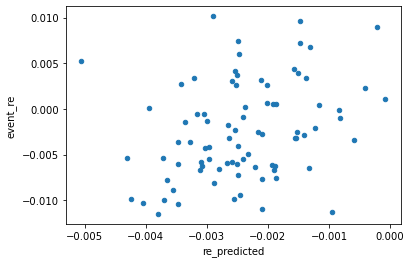

In [54]:
ump_stats.loc[ump_stats['pa']>6000].plot.scatter(x='re_predicted', y='event_re')

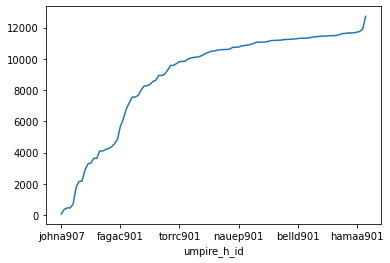

In [55]:
ump_stats.sort_values(by='pa').pa.plot()

In [56]:
ump_stats['re_effect_obs'] = ump_stats['event_re']-ump_stats['re_predicted']
ump_stats.sort_values(by='pa')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
johna907,77,-0.011362,0.000550,0.011913
pattm903,376,0.006998,-0.034697,-0.041695
bacoj901,467,0.002507,0.016065,0.013559
tosia901,468,0.014332,0.001839,-0.012493
millb903,708,0.008716,0.037627,0.028911
...,...,...,...,...
cedeg901,11671,-0.002406,-0.000892,0.001514
hamaa901,11713,-0.003466,-0.010380,-0.006914
millb901,11759,-0.003695,-0.010019,-0.006324


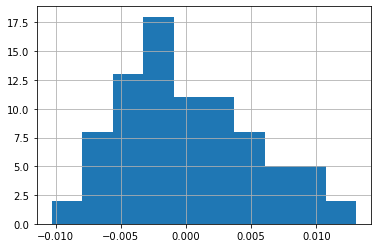

In [57]:
ump_stats.loc[ump_stats['pa']>6000].re_effect_obs.hist()

In [58]:
ump_stats.loc[ump_stats['pa']>6000].sort_values(by='re_effect_obs')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
drecb901,8643,-0.000945,-0.011253,-0.010308
blasc901,10887,-0.002102,-0.010971,-0.008869
blakr901,11227,-0.003792,-0.011512,-0.007720
wendh902,10744,-0.002562,-0.009861,-0.007300
estam901,11266,-0.002455,-0.009389,-0.006934
...,...,...,...,...
gonzm901,11466,-0.000214,0.008945,0.009159
porta901,11083,-0.002481,0.007453,0.009934
knigb901,9287,-0.005059,0.005277,0.010336
